<a href="https://colab.research.google.com/github/marii1109936/Elaborato_finale_misoginia/blob/main/Elaborato_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
!pip install --quiet optuna
!pip install --quiet emoji
import pandas as pd
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from nltk.corpus import stopwords
import optuna
import re
import emoji
import matplotlib.pyplot as plt
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
data_train= open('/gdrive/MyDrive/Elaborato_finale/Data/AMI2020_training_raw_anon.tsv')
data_test= open('/gdrive/MyDrive/Elaborato_finale/Data/AMI2020_test_raw_gold_anon.tsv')

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r'&#x[0-9a-fA-F]+;', '', text)
    text = re.sub(r'&#\d+;', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = ''.join([c for c in text if c not in string.punctuation])
    text = re.sub(r'#', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [7]:
import csv
data= csv.reader (open('/gdrive/MyDrive/Elaborato_finale/Data/AMI2020_training_raw_anon.tsv'))
data= [i for i in data]
data[150]

['150\tAlessandra fai poco la figa che lo sappiamo che mo torni a casa a piangere e poi chiami <MENTION_1> per avere il numero del palestrato #primoappuntamento\t1\t0']

In [8]:
righe = []

with open("/gdrive/MyDrive/Elaborato_finale/Data/AMI2020_training_raw_anon.tsv", encoding="utf-8") as f:
    for line_num, line in enumerate(f):
        parts = line.strip().split('\t')
        i = 0
        while i + 3 < len(parts):
            id_ = parts[i].strip()
            text = parts[i + 1].strip()
            misogynous = parts[i + 2].strip()
            aggressiveness = parts[i + 3].strip()

            if misogynous in ['0', '1'] and aggressiveness in ['0', '1']:
                righe.append({
                    'id': id_,
                    'text': text,
                    'misogynous': int(misogynous),
                    'aggressiveness': int(aggressiveness)
                })

            i += 4

df_train = pd.DataFrame(righe)
df_train

,id,text,misogynous,aggressiveness
0,1,<MENTION_1> <MENTION_2> Fatti trovare te lo d...,1,1
1,2,<MENTION_1> Tu dovresti ricominciare dai semaf...,1,1
2,3,"""Amore,sei presentabile? Xchè così via Skype t...",1,1
3,4,<MENTION_1> Salvo poi mandare la culona a Mosc...,1,0
4,5,"<MENTION_1> <MENTION_2> Vediamo Gentiloni, è o...",1,1
...,...,...,...,...
4995,4996,non ci posso credere sono queste le cose che m...,0,0
4996,4997,sono così incazzata! dovete smetterla di consi...,0,0
4997,4998,SENTITE PORCA PUTTANA TAE NON PUÒ POSTARE SUL ...,0,0
4998,4999,ma vaffanculo senti che cazzo me li fai te i c...,0,0


In [9]:
df_test= pd.read_csv('/gdrive/MyDrive/Elaborato_finale/Data/AMI2020_test_raw_gold_anon.tsv', sep= "\t")
df_test

,id,text,misogynous,aggressiveness
0,5001,Aveva voglia di gridare tutta la mia rabbia ma...,0,0
1,5002,Lei è acida perché non ha figli penso che dare...,0,0
2,5003,Ma quanto è brutto sentirsi dire dal proprio f...,0,0
3,5004,Per chi ci facciamo venire il groppo in gola s...,0,0
4,5005,<MENTION_1> Ti sborro io,1,0
...,...,...,...,...
995,5996,"<MENTION_1> O si, mi piacerebbe tantissimo, ch...",1,1
996,5997,<MENTION_1> Lo so ognuno ha la sua croce se va...,1,0
997,5998,<MENTION_1> madonna qui partono gli schiaffi,0,0
998,5999,<MENTION_1> Che bel culo,1,0


In [10]:
df_train['text'] = df_train['text'].apply(preprocess)
df_train['text']

,text
0,fatti trovare te do volentieri sborro bocca
1,dovresti ricominciare semafori fare lavavetrim...
2,amoresei presentabile xchè così via skype cono...
3,salvo poi mandare culona mosca aummaumm farsi ...
4,vediamo gentiloni ora finirla essere servili p...
...,...
4995,posso credere cose incazzare porca puttana sch...
4996,così incazzata dovete smetterla considerare id...
4997,sentite porca puttana tae può postare fancafè ...
4998,vaffanculo senti cazzo me te compiti porca put...


In [11]:
df_test['text'] = df_test['text'].apply(preprocess)
df_test['text']

,text
0,voglia gridare tutta rabbia quel maledetto nod...
1,acida figli penso darebbe fastidio qualsiasi d...
2,brutto sentirsi dire proprio fidanzato acida s...
3,venire groppo gola stasera techetechete
4,sborro
...,...
995,piacerebbe tantissimo voglia piantartelo bocca...
996,so ognuno croce vai colombo vedi na regazzina ...
997,madonna qui partono schiaffi
998,bel culo


In [12]:
X_train = df_train['text']
y_train = df_train['misogynous']

X_test = df_test['text']
y_test = df_test['misogynous']

In [ ]:
#Logistic Regression
def objective_lr(trial):
    C = trial.suggest_float("lr_c", 1e-4, 100.0, log=True)
    model = LogisticRegression(C=C, max_iter=1000)

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return accuracy_score(y_test, preds)

#SVC
def objective_svc(trial):
    C = trial.suggest_float("svc_c", 1e-3, 100.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)
    model = SVC(C=C, kernel=kernel, gamma=gamma)

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return accuracy_score(y_test, preds)

# Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, max_features=max_features, random_state=42)

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return accuracy_score(y_test, preds)

In [ ]:
print("Ottimizzazione Logistic Regression...")
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=100)

print("Ottimizzazione SVC...")
study_svc = optuna.create_study(direction="maximize")
study_svc.optimize(objective_svc, n_trials=100)

print("Ottimizzazione Random Forest...")
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100)

[I 2025-08-13 08:10:34,727] A new study created in memory with name: no-name-a730b4cc-1cfd-48af-966d-06ba914df8e6


Ottimizzazione Logistic Regression...


[I 2025-08-13 08:10:34,987] Trial 0 finished with value: 0.505 and parameters: {'lr_c': 0.0019355209006283866}. Best is trial 0 with value: 0.505.
[I 2025-08-13 08:10:35,174] Trial 1 finished with value: 0.692 and parameters: {'lr_c': 1.8972653335097487}. Best is trial 1 with value: 0.692.
[I 2025-08-13 08:10:35,361] Trial 2 finished with value: 0.687 and parameters: {'lr_c': 4.57602542340449}. Best is trial 1 with value: 0.692.
[I 2025-08-13 08:10:35,563] Trial 3 finished with value: 0.683 and parameters: {'lr_c': 15.236452930366427}. Best is trial 1 with value: 0.692.
[I 2025-08-13 08:10:35,711] Trial 4 finished with value: 0.717 and parameters: {'lr_c': 0.009950861662209978}. Best is trial 4 with value: 0.717.
[I 2025-08-13 08:10:35,858] Trial 5 finished with value: 0.652 and parameters: {'lr_c': 0.006018614282525224}. Best is trial 4 with value: 0.717.
[I 2025-08-13 08:10:36,074] Trial 6 finished with value: 0.686 and parameters: {'lr_c': 24.772147330630617}. Best is trial 4 with v

Ottimizzazione SVC...


[I 2025-08-13 08:10:56,201] Trial 0 finished with value: 0.728 and parameters: {'svc_c': 44.500863247884624, 'kernel': 'rbf', 'gamma': 0.00016217750002961545}. Best is trial 0 with value: 0.728.
[I 2025-08-13 08:10:58,524] Trial 1 finished with value: 0.643 and parameters: {'svc_c': 0.07800719767909554, 'kernel': 'linear', 'gamma': 0.04844654029139697}. Best is trial 0 with value: 0.728.
[I 2025-08-13 08:11:01,221] Trial 2 finished with value: 0.657 and parameters: {'svc_c': 47.46673605814252, 'kernel': 'linear', 'gamma': 0.016467123373679296}. Best is trial 0 with value: 0.728.
[I 2025-08-13 08:11:04,435] Trial 3 finished with value: 0.709 and parameters: {'svc_c': 0.2793371830112663, 'kernel': 'rbf', 'gamma': 0.06289978488490217}. Best is trial 0 with value: 0.728.
[I 2025-08-13 08:11:06,250] Trial 4 finished with value: 0.673 and parameters: {'svc_c': 0.319276398905229, 'kernel': 'linear', 'gamma': 0.00021006061766191394}. Best is trial 0 with value: 0.728.
[I 2025-08-13 08:11:09,44

Ottimizzazione Random Forest...


[I 2025-08-13 08:15:21,085] Trial 0 finished with value: 0.699 and parameters: {'n_estimators': 194, 'max_depth': 14, 'max_features': 'log2'}. Best is trial 0 with value: 0.699.
[I 2025-08-13 08:15:21,427] Trial 1 finished with value: 0.606 and parameters: {'n_estimators': 63, 'max_depth': 28, 'max_features': 'log2'}. Best is trial 0 with value: 0.699.
[I 2025-08-13 08:15:22,180] Trial 2 finished with value: 0.607 and parameters: {'n_estimators': 83, 'max_depth': 27, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.699.
[I 2025-08-13 08:15:22,694] Trial 3 finished with value: 0.556 and parameters: {'n_estimators': 94, 'max_depth': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.699.
[I 2025-08-13 08:15:23,187] Trial 4 finished with value: 0.699 and parameters: {'n_estimators': 195, 'max_depth': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.699.
[I 2025-08-13 08:15:46,480] Trial 5 finished with value: 0.52 and parameters: {'n_estimators': 268, 'max_depth': 1

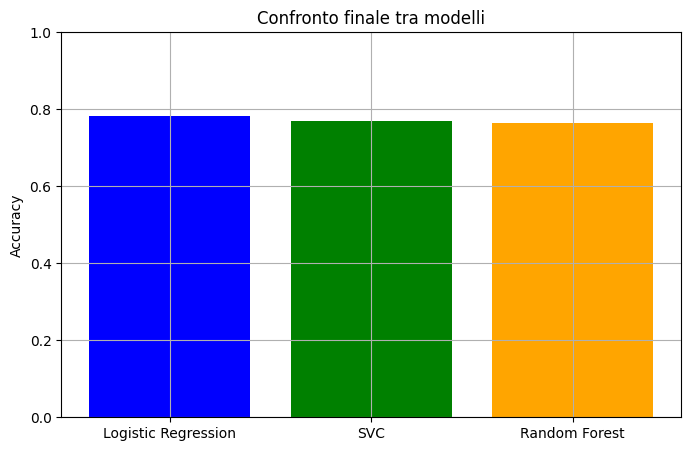

Logistic Regression
 - Accuracy: 0.7820
 - Parametri: {'lr_c': 0.029631773064266637}

SVC
 - Accuracy: 0.7700
 - Parametri: {'svc_c': 0.019827704321710698, 'kernel': 'linear', 'gamma': 0.0459491139211682}

Random Forest
 - Accuracy: 0.7650
 - Parametri: {'n_estimators': 265, 'max_depth': 19, 'max_features': 'log2'}



In [ ]:
final_scores = {
    "Logistic Regression": study_lr.best_value,
    "SVC": study_svc.best_value,
    "Random Forest": study_rf.best_value
}

#Grafico
plt.figure(figsize=(8,5))
plt.bar(final_scores.keys(), final_scores.values(), color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Confronto finale tra modelli")
plt.grid(True)
plt.show()

print(f"Logistic Regression\n - Accuracy: {study_lr.best_value:.4f}\n - Parametri: {study_lr.best_params}\n")
print(f"SVC\n - Accuracy: {study_svc.best_value:.4f}\n - Parametri: {study_svc.best_params}\n")
print(f"Random Forest\n - Accuracy: {study_rf.best_value:.4f}\n - Parametri: {study_rf.best_params}\n")

In [ ]:
best_model_name = max(final_scores, key=final_scores.get)
best_score = final_scores[best_model_name]

print("Miglior modello complessivo:")
print(f"{best_model_name} con Accuracy = {best_score:.4f}")

Miglior modello complessivo:
Logistic Regression con Accuracy = 0.7820


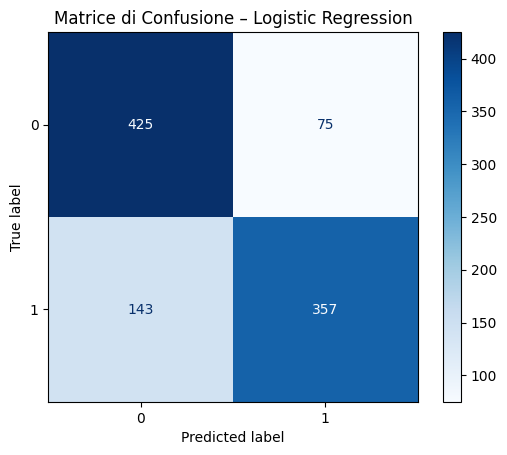

Accuracy Logistic Regression: 0.7820


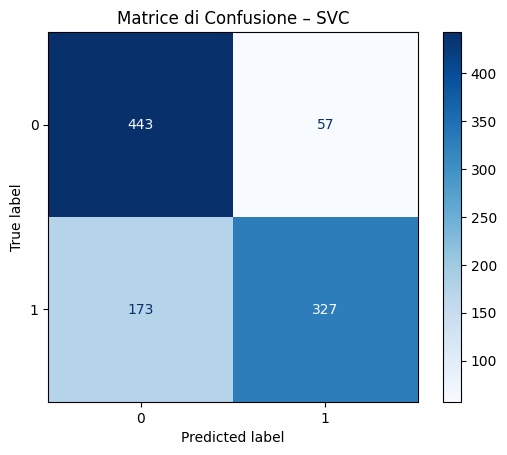

Accuracy SVC: 0.7700


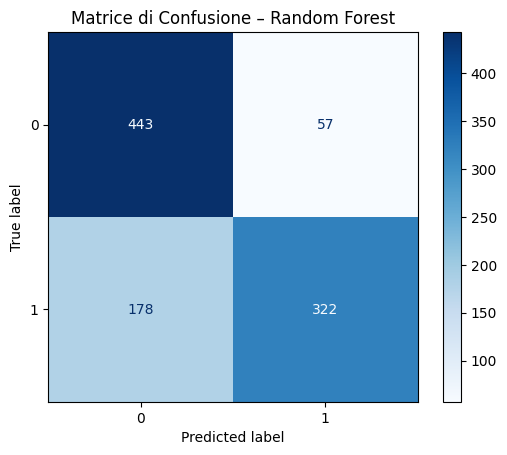

Accuracy Random Forest: 0.7650


In [ ]:
def mc(model_name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matrice di Confusione – {model_name}")
    plt.grid(False)
    plt.show()
    print(f"Accuracy {model_name}: {accuracy_score(y_test, y_pred):.4f}")

params_lr = study_lr.best_params
model_lr = LogisticRegression(C=params_lr["lr_c"], max_iter=1000)
mc("Logistic Regression", model_lr, X_train, y_train, X_test, y_test)

params_svc = study_svc.best_params
model_svc = SVC(C=params_svc["svc_c"], kernel=params_svc["kernel"], gamma=params_svc["gamma"])
mc("SVC", model_svc, X_train, y_train, X_test, y_test)

params_rf = study_rf.best_params
model_rf = RandomForestClassifier(
    n_estimators=params_rf["n_estimators"],
    max_depth=params_rf["max_depth"],
    max_features=params_rf["max_features"],
    random_state=42
)
mc("Random Forest", model_rf, X_train, y_train, X_test, y_test)

In [ ]:
save_dir = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia"
os.makedirs(save_dir, exist_ok=True)
if best_model_name == "Logistic Regression":
    params = study_lr.best_params
    model = LogisticRegression(C=params["lr_c"], max_iter=1000)

elif best_model_name == "SVC":
    params = study_svc.best_params
    model = SVC(C=params["svc_c"], kernel=params["kernel"], gamma=params["gamma"])

else:
    params = study_rf.best_params
    model = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        max_features=params["max_features"],
        random_state=42
    )
pipeline_finale = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', model)
])
pipeline_finale.fit(X_train, y_train)

file_modello = os.path.join(save_dir, f"Modello_{best_model_name.replace(' ', '_')}.joblib")
joblib.dump(pipeline_finale, file_modello)

['/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/Modello_Logistic_Regression.joblib']

In [16]:
test_label= df_test['misogynous'].tolist()
test_text= df_test['text'].tolist()
train_label= df_train['misogynous'].tolist()
train_text= df_train['text'].tolist()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1724472640.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (


Epoch,Training Loss,Validation Loss
1,0.437400,0.732216
2,0.293000,0.658664
3,0.251100,0.721984
4,0.218000,0.685962
5,0.198200,0.714597


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61       500
           1       0.63      0.86      0.73       500

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000



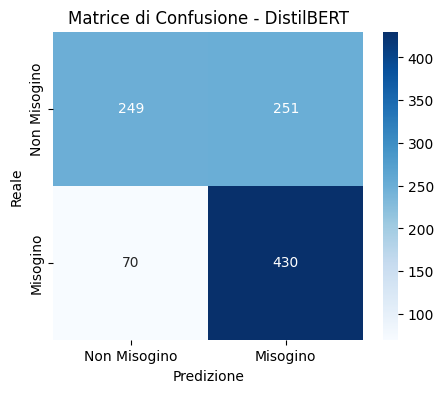

('/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/distilbert_model/tokenizer_config.json',
 '/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/distilbert_model/special_tokens_map.json',
 '/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/distilbert_model/vocab.txt',
 '/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/distilbert_model/added_tokens.json')

In [ ]:
import os
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,  DataCollatorWithPadding
import torch
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

save_dir = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia"
os.makedirs(save_dir, exist_ok=True)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

train_encodings = tokenizer(train_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

class CustomDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = CustomDataset (train_encodings, train_label)
test_dataset = CustomDataset (test_encodings, test_label)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=2)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir= "./results" ,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy= "epoch" ,
    logging_strategy= "epoch",
    report_to="none"
)

trainer = Trainer (
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
)

trainer.train()

predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1)
print("Classification Report:")
print(classification_report(predictions.label_ids, preds.numpy()))

cm = confusion_matrix(predictions.label_ids, preds.numpy())
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non Misogino", "Misogino"], yticklabels=["Non Misogino", "Misogino"])
plt.xlabel("Predizione")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - DistilBERT")
plt.show()

model_path = os.path.join(save_dir, "distilbert_model")
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

[I 2025-08-21 15:39:48,618] A new study created in memory with name: no-name-a3b72fc6-3e2e-4924-b1a6-7555d80deb3b
[I 2025-08-21 15:40:08,102] Trial 0 finished with value: 0.7096247960848288 and parameters: {'lr': 0.03363391507471324, 'epoch': 108, 'wordNgrams': 7, 'dim': 100}. Best is trial 0 with value: 0.7096247960848288.
[I 2025-08-21 15:41:02,012] Trial 1 finished with value: 0.6949006050129646 and parameters: {'lr': 0.2262826649670884, 'epoch': 165, 'wordNgrams': 9, 'dim': 200}. Best is trial 0 with value: 0.7096247960848288.
[I 2025-08-21 15:41:10,511] Trial 2 finished with value: 0.7011128775834659 and parameters: {'lr': 0.04393421415226573, 'epoch': 27, 'wordNgrams': 6, 'dim': 200}. Best is trial 0 with value: 0.7096247960848288.
[I 2025-08-21 15:41:12,782] Trial 3 finished with value: 0.7030567685589519 and parameters: {'lr': 0.7147109000521128, 'epoch': 10, 'wordNgrams': 5, 'dim': 100}. Best is trial 0 with value: 0.7096247960848288.
[I 2025-08-21 15:41:15,582] Trial 4 finish

Migliori iperparametri trovati: {'lr': 0.10396856501864749, 'epoch': 51, 'wordNgrams': 3, 'dim': 200}
Accuracy: 0.7242
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.48      0.59       500
           1       0.62      0.86      0.72       500

    accuracy                           0.67      1000
   macro avg       0.70      0.67      0.66      1000
weighted avg       0.70      0.67      0.66      1000



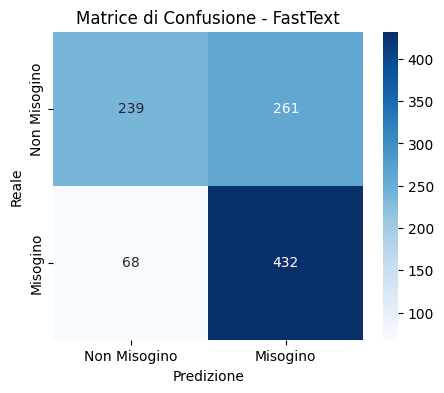

In [17]:
!pip install optuna
import optuna
import os
import fasttext
!pip install numpy==1.26.4
!pip install fasttext==0.9.2
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score

save_dir = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia"
os.makedirs(save_dir, exist_ok=True)

def save_fasttext_format(df, text_col, label_col, filename):
  with open(filename, 'w', encoding='utf-8') as f:
      for _, row in df.iterrows():
        label = f"__label__{int(row['misogynous'])}"
        text = str(row["text"]).replace("\n", " ").strip()
        if text:
          f.write(f"{label} {text}\n")

save_fasttext_format(df_train, "text", "misogynous", "train_ft.txt")
save_fasttext_format(df_test, "text", "misogynous", "test_ft.txt")

def objective(trial):
    lr = trial.suggest_float("lr", 0.005, 1.0, log=True)
    epoch = trial.suggest_int("epoch", 5, 200)
    wordNgrams = trial.suggest_int("wordNgrams", 3, 10)
    dim = trial.suggest_categorical("dim", [50, 100, 150, 200])
    try:
      model = fasttext.train_supervised(input="train_ft.txt", lr=lr, epoch=epoch, wordNgrams=wordNgrams, dim=dim)
    except RuntimeError:
      return 0.0

    y_true = []
    y_pred = []

    for _, row in df_test.iterrows():
        text = str(row["text"]).replace("\n", " ").strip()
        true_label = int(row["misogynous"])
        if text:
          pred_label = model.predict(text, k=1)[0][0]
          pred_label = int(pred_label.replace("__label__", ""))
          y_true.append(true_label)
          y_pred.append(pred_label)
    return f1_score(y_true, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Migliori iperparametri trovati:", study.best_params)
print(f"Accuracy: {study.best_value:.4f}")

best_params = study.best_params
final_model = fasttext.train_supervised(
    input="train_ft.txt",
    lr=best_params["lr"],
    epoch=best_params["epoch"],
    wordNgrams=best_params["wordNgrams"],
    dim=best_params["dim"]
)

y_true = []
y_pred = []

for _, row in df_test.iterrows():
    text = str(row["text"]).replace("\n", " ").strip()
    label = int(row["misogynous"])
    if text:
      pred_label = final_model.predict(text, k=1)[0][0]
      pred_label = int(pred_label.replace("__label__", ""))
      y_true.append(label)
      y_pred.append(pred_label)

print("Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non Misogino", "Misogino"],
            yticklabels=["Non Misogino", "Misogino"])
plt.xlabel("Predizione")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - FastText")
plt.show()

model_path = os.path.join(save_dir, "fasttext_model.bin")
final_model.save_model(model_path)


 Risultati FastText
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.64      0.78      1120

    accuracy                           0.64      1120
   macro avg       0.50      0.32      0.39      1120
weighted avg       1.00      0.64      0.78      1120



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


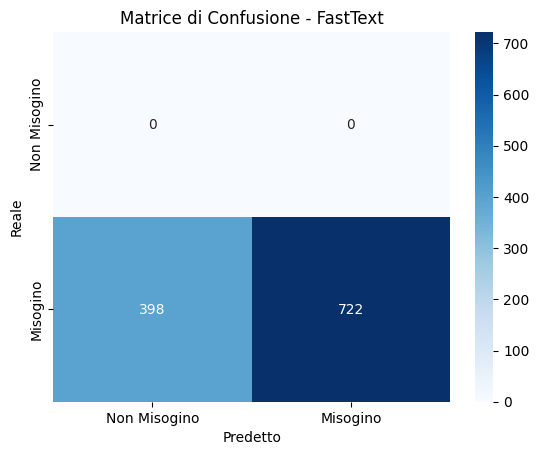


 Risultati DistilBERT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.26      0.41      1120

    accuracy                           0.26      1120
   macro avg       0.50      0.13      0.21      1120
weighted avg       1.00      0.26      0.41      1120



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


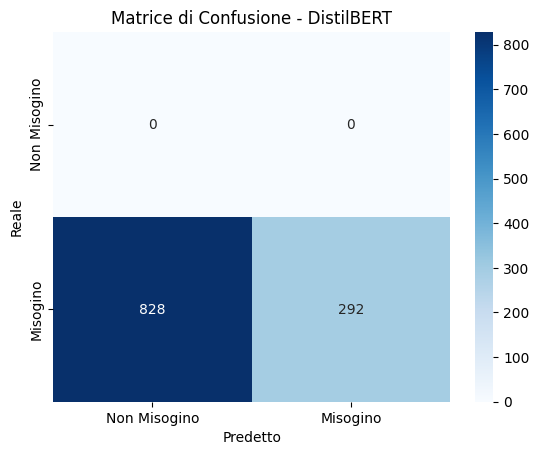


 Risultati Logistic Regression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.21      0.35      1120

    accuracy                           0.21      1120
   macro avg       0.50      0.11      0.17      1120
weighted avg       1.00      0.21      0.35      1120



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


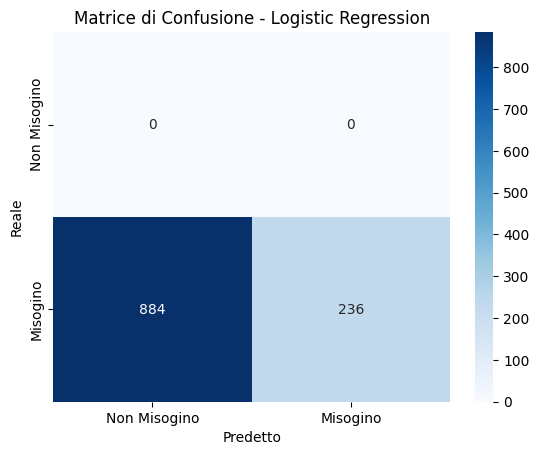

In [3]:
!pip install openpyxl
!pip install numpy==1.26.4
!pip install fasttext==0.9.2
import pandas as pd
from google.colab import drive
import fasttext
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = "/gdrive/MyDrive/Elaborato_finale/Data/implicit_misogyny_idtext.xlsx"
fasttext_model_path = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/fasttext_model.bin"
distilbert_model_path = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/distilbert_model"
pipeline_model_path = "/gdrive/MyDrive/Elaborato_finale/modelli_misoginia/Modello_Logistic_Regression.joblib"

df = pd.read_excel(dataset_path)
df["text"] = df["text"].fillna("")
texts = df["text"].tolist()
labels = [1] * len(texts)

ft_model = fasttext.load_model(fasttext_model_path)
preds_fasttext = []
for t in texts:
    t_clean = str(t).replace("\n", " ").strip()
    if t_clean:
        label, _ = ft_model.predict(t_clean)
        label_num = int(label[0].replace("__label__", ""))
        preds_fasttext.append(label_num)
    else:
        preds_fasttext.append(None)

tokenizer = DistilBertTokenizer.from_pretrained(distilbert_model_path)
bert_model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_path)
bert_model.eval()
preds_bert = []
for t in texts:
    if t.strip():
        inputs = tokenizer(t, truncation=True, padding=True, return_tensors="pt")
        with torch.no_grad():
            outputs = bert_model(**inputs)
        pred_class = outputs.logits.argmax(dim=1).item()
        preds_bert.append(pred_class)
    else:
        preds_bert.append(None)

pipeline_model = joblib.load(pipeline_model_path)
preds_logreg = pipeline_model.predict(texts).tolist()

def evaluate_model(name, y_true, y_pred):
    print(f"\n Risultati {name}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non Misogino", "Misogino"],
                yticklabels=["Non Misogino", "Misogino"])
    plt.title(f"Matrice di Confusione - {name}")
    plt.xlabel("Predetto")
    plt.ylabel("Reale")
    plt.show()

if labels is not None:
    evaluate_model("FastText", labels, preds_fasttext)
    evaluate_model("DistilBERT", labels, preds_bert)
    evaluate_model("Logistic Regression", labels, preds_logreg)
else:
    print("Nessuna etichetta trovata: calcolo solo le predizioni.")